# Ensemble trends: prra + prsn

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'prra'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
conf_prsn = [v for v in libs.vars.variables() if v['variable_id'] == 'prsn'][0]
conf_pr = [v for v in libs.vars.variables() if v['variable_id'] == 'pr'][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series_prra = libs.local.get_ensemble_series(variable_id, experiment)
ensemble_time_series_prsn = libs.local.get_ensemble_series('prsn', experiment)

for key in ensemble_time_series_prsn:
    ensemble_time_series_prsn[key].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }


obs_arr = []
for obs in conf_pr['obs']:
    obs_data = libs.local.get_obs(**obs)

    obs_arr.append({
        'color': obs_data.attrs['color'],
        'data': obs_data * 86400 / 100, # Convert s -> d, fix factor 100
        'label': obs_data.attrs['label']
    })
    
for obs in conf_prsn['obs']:
    obs_data = libs.local.get_obs(**obs)

    obs_arr.append({
        'color': obs_data.attrs['color'],
        'data': obs_data * 86400 / 100, # Convert s -> d, fix factor 100
        'label': obs_data.attrs['label']
    })
    
obs_ts, obs_ts_smooth = libs.ensemble.time_series_weighted(
    obs_arr,
    weight,
    fillna=None,
    weighting_method=conf['weighting_method'],
    weighting_process=conf['weighting_process']
)

obs_ts_keys = {}
for i, item in enumerate(obs_ts):
    key = ' '.join([item['label'], item['data'].name])
    processed_data = item['data']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    processed_data.attrs['color'] = item['color']
    processed_data.attrs['label'] = key
    
    # Groupby + mean to resample from monthly time to year, then add to ensemble datasets
    obs_ts_keys[key] = processed_data


ds_obs = xarray.Dataset(data_vars=obs_ts_keys)
ds_obs['ERA5 tp - sf'] = ds_obs['ERA5 tp'] - ds_obs['ERA5 sf'] # Calculate rainfall from pr - prsn
ds_obs['ERA5 tp - sf'].attrs['plot_kwargs'] = { 'linewidth': 3, 'zorder': 10 }
ds_obs['ERA5 tp - sf'].attrs['color'] = ds_obs['ERA5 tp'].attrs['color']
ds_obs['ERA5 tp - sf'].attrs['label'] = 'ERA5 tp - sf'
ds_obs['ERA5 sf'].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)), 'linewidth': 3, 'zorder': 10 }

del ds_obs['ERA5 tp']

## Time series

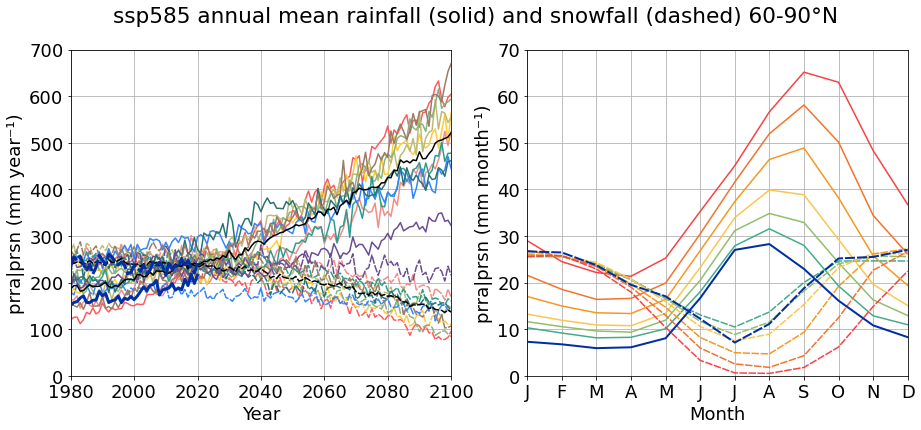

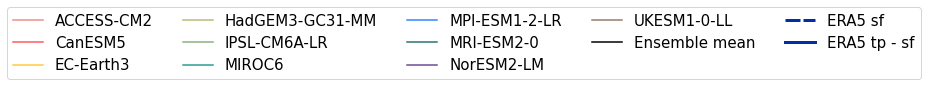

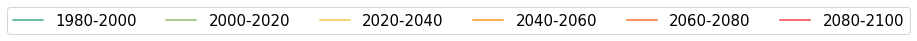

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(
    f'''{experiment} annual mean rainfall (solid) and snowfall (dashed) 60-90°N'''
)

vars_series = [
    { 'calc_mean': True, 'data': ensemble_time_series_prra },
    { 'calc_mean': True, 'data': ensemble_time_series_prsn },
    { 'calc_mean': False, 'data': ds_obs },
]
plot_arr = []
variables_keys = []
for item in vars_series:
    item_processed = item['data'].groupby('time.year').mean('time')
    item_processed *= 360 # convert to annual

    if item['calc_mean']:
        item_processed = libs.ensemble.calc_variable_mean(item_processed)

    variables_keys.extend(list(item_processed))
    plot_arr.append(item_processed)

variables_keys = list(dict.fromkeys(variables_keys))
plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }

libs.plot.time_series_from_vars(
    plot_arr,
    ax=axes[0],
    fig=fig,
    show_legend=False,
    xattr='year',
    variables=variables_keys,
    ylabel='prra|prsn (mm year⁻¹)',
    yrange=(0, 700)
);

arr = []
for item in vars_series[0:-1]:
    for s in libs.vars.time_slices_20y():
        s_label = s['label']
        data_slice = (item['data'] * 30).sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']

        arr.append(data_slice)
        

obs_compare_slice = libs.vars.time_slices_20y()[0]['slice']
for ds_var in ds_obs:
    # Not ensemble mean, but using name for ease in monthly variability plot
    obs_ts_slice = xarray.Dataset(
        data_vars={ 
            'Ensemble mean': (ds_obs[ds_var] * 30).sel(**obs_compare_slice).groupby('time.month').mean('time')
        }
    )
    obs_ts_slice['Ensemble mean'].attrs['plot_kwargs']['linewidth'] = 2
    arr.append(obs_ts_slice)

libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    legend_below=True,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel='prra|prsn (mm month⁻¹)',
    yrange=(0, 70)
);

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 6, 'exclude': ds_obs.keys() },
    ]
)

In [5]:
prra_annual_mean = plot_arr[0]
prsn_annual_mean = plot_arr[1]

def get_first_of_consecutive(arr):
    consecutive_arr = [arr[0]]
    for i, y in enumerate(arr[1:]):
        if arr[i] != y + 1:
            return consecutive_arr
        
        consecutive_arr.append(y)
    
    return consecutive_arr
    

first_consecutive_rain = []
first_consecutive_rain_no_mpi = []
print('First year of permanent dominant rainfall')
for v in prra_annual_mean:
    rain_dominating_years = prra_annual_mean[v].where(prra_annual_mean[v] > prsn_annual_mean[v], drop=True).year.values
    
    # Reverse
    rain_dominating_years = rain_dominating_years[::-1]
    
    # Filter to get first of consecutive 
    rain_consecutive_years = get_first_of_consecutive(rain_dominating_years)
    v != 'Ensemble mean' and first_consecutive_rain.append(rain_consecutive_years[-1])
    v not in ['Ensemble mean', 'MPI-ESM1-2-LR'] and first_consecutive_rain_no_mpi.append(rain_consecutive_years[-1])
    
    print(v, rain_consecutive_years[-1])
    
first_min = min(first_consecutive_rain)
first_max = max(first_consecutive_rain)
print('-----')
print('Range', first_min, '-', first_max)
print('Median', first_min + ((first_max - first_min) / 2))
print('Mean', sum(first_consecutive_rain) / len(first_consecutive_rain))

first_min = min(first_consecutive_rain_no_mpi)
first_max = max(first_consecutive_rain_no_mpi)
print('-----')
print('EXCLUDING MPI:')
print('Range', first_min, '-', first_max)
print('Median', first_min + ((first_max - first_min) / 2))
print('Mean', sum(first_consecutive_rain_no_mpi) / len(first_consecutive_rain_no_mpi))

First year of permanent dominant rainfall
ACCESS-CM2 2044
CanESM5 2019
EC-Earth3 2037
HadGEM3-GC31-MM 2030
IPSL-CM6A-LR 2033
MIROC6 2035
MPI-ESM1-2-LR 1980
MRI-ESM2-0 2006
NorESM2-LM 2063
UKESM1-0-LL 2030
Ensemble mean 2019
-----
Range 1980 - 2063
Median 2021.5
Mean 2027.7
-----
EXCLUDING MPI:
Range 2006 - 2063
Median 2034.5
Mean 2033.0


In [6]:
prra_annual_mean = plot_arr[0]
prsn_annual_mean = plot_arr[1]

for obj in [{ 'ds': prra_annual_mean, 'key': 'Rain' }, { 'ds': prsn_annual_mean, 'key': 'Snow' }]:
    print('-----', obj['key'], '-----')
    ds = obj['ds']
    libs.analysis.calc_diffs(ds, unit='mm', relative=True)    

----- Rain -----
ACCESS-CM2
-> 1980-2010: 172.39mm
-> 2080-2100: 433.42mm
-> delta: 151.41%
CanESM5
-> 1980-2010: 149.75mm
-> 2080-2100: 562.48mm
-> delta: 275.62%
EC-Earth3
-> 1980-2010: 209.93mm
-> 2080-2100: 501.33mm
-> delta: 138.81%
HadGEM3-GC31-MM
-> 1980-2010: 202.02mm
-> 2080-2100: 511.11mm
-> delta: 153.01%
IPSL-CM6A-LR
-> 1980-2010: 219.34mm
-> 2080-2100: 540.57mm
-> delta: 146.46%
MIROC6
-> 1980-2010: 210.68mm
-> 2080-2100: 441.71mm
-> delta: 109.66%
MPI-ESM1-2-LR
-> 1980-2010: 265.28mm
-> 2080-2100: 419.05mm
-> delta: 57.96%
MRI-ESM2-0
-> 1980-2010: 214.07mm
-> 2080-2100: 431.02mm
-> delta: 101.35%
NorESM2-LM
-> 1980-2010: 212.26mm
-> 2080-2100: 323.26mm
-> delta: 52.29%
UKESM1-0-LL
-> 1980-2010: 170.05mm
-> 2080-2100: 561.67mm
-> delta: 230.30%
Ensemble mean
-> 1980-2010: 202.58mm
-> 2080-2100: 472.56mm
-> delta: 133.28%

Range 52.29299333893715 - 275.6185389620433
Median 163.95576615049023
Mean 141.68653941435477

----- Snow -----
ACCESS-CM2
-> 1980-2010: 258.39mm
-> 2080

### Higher/lower latitude regions of prra/pr

In [7]:
def create_masked_ts(ensemble, weight, nsidc_mask, region, time_series_weighted_method):
    data_vars = {}

    for i, item in enumerate(ensemble):
        processed_data = item['data']
        processed_data.attrs['color'] = item['color']
        processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
        item_filtered = processed_data.where(np.isin(nsidc_mask.values, region['values']))
        item_weighted = item_filtered.weighted(weight)
        item_reduced = getattr(
            item_weighted, 
            time_series_weighted_method
        )(dim=item_weighted.weights.dims, skipna=True)

        data_vars[item['label']] = item_reduced

    ds = xarray.Dataset(data_vars=data_vars)
    ds = libs.ensemble.calc_variable_mean(ds)
    
    return ds

In [8]:
ensemble_pr, weight_pr = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    'pr',
    preprocess=conf_pr['preprocess']
)

ensemble_prra, weight_prra = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    'prra',
    preprocess=conf['preprocess']
)

region_lower = [r for r in libs.vars.nsidc_regions() if r['label'] == 'Lower Latitudes'][0]
region_higher = [r for r in libs.vars.nsidc_regions() if r['label'] == 'Higher Latitudes'][0]

path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask

In [9]:
pr_kwargs = {
    'ensemble': ensemble_pr,
    'nsidc_mask': nsidc_mask,
    'time_series_weighted_method': time_series_weighted_method,
    'weight': weight_pr,
}
#ds_pr = create_masked_ts(region=region_all, **pr_kwargs)
ds_pr_lower = create_masked_ts(region=region_lower,  **pr_kwargs)
ds_pr_higher = create_masked_ts(region=region_higher,  **pr_kwargs)

prra_kwargs = {
    'ensemble': ensemble_prra,
    'nsidc_mask': nsidc_mask,
    'time_series_weighted_method': time_series_weighted_method,
    'weight': weight_prra,
}
#ds_prra = create_masked_ts(region=region_all, **prra_kwargs)
ds_prra_lower = create_masked_ts(region=region_lower, **prra_kwargs)
ds_prra_higher = create_masked_ts(region=region_higher, **prra_kwargs)

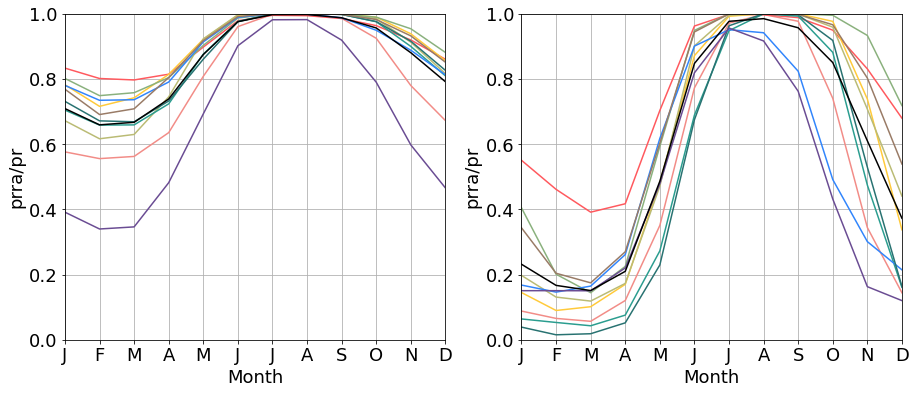

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

vars_series = [
    ds_prra_lower / ds_pr_lower,
    ds_prra_higher / ds_pr_higher
]

for i, item in enumerate(vars_series):
    s = libs.vars.time_slices_20y()[-1]
    s_label = s['label']
    data_slice = item.sel(**s['slice']).groupby('time.month').mean('time')

    libs.plot.monthly_variability(
        data_slice,
        ax=axes[i],
        fig=fig,
        show_legend=False,
        ylabel='prra/pr',
        yrange=(0, 1)
    );

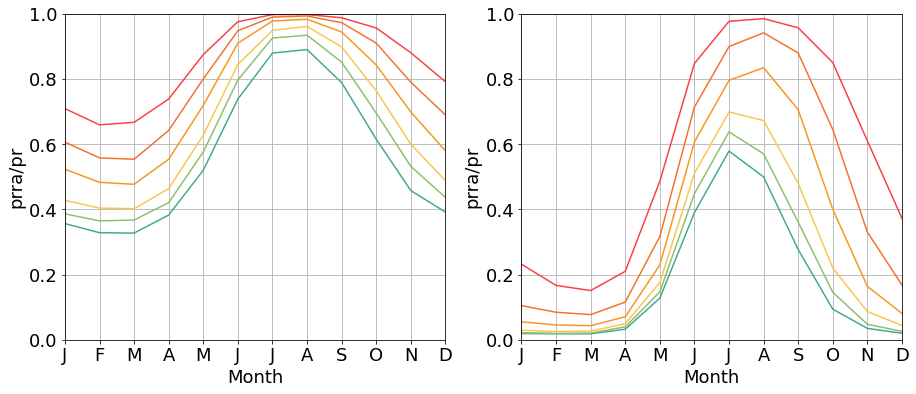

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

vars_series = [
    ds_prra_lower / ds_pr_lower,
    ds_prra_higher / ds_pr_higher
]

for i, item in enumerate(vars_series):
    arr = []
    for s in libs.vars.time_slices_20y():
        s_label = s['label']
        data_slice = item.sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        arr.append(data_slice)

    libs.plot.monthly_variability(
        arr,
        ax=axes[i],
        fig=fig,
        show_legend=False,
        variables=['Ensemble mean'],
        ylabel='prra/pr',
        yrange=(0, 1)
    );